In [74]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import warnings

# Подавляем предупреждения
warnings.simplefilter('ignore', ValueWarning)

In [75]:
data = pd.read_excel("./data/Infl_unempl.xlsx", parse_dates=["Date"])
data = data.dropna()
data = data.sort_values("Date").reset_index(drop=True)
data.set_index("Date", inplace=True)
data

,Inflation,Unempoyment
Date,,
2016-01-01,7.09,7.0
2017-01-01,3.70,6.6
2018-01-01,2.88,6.1
2019-01-01,4.48,6.5
2020-01-01,3.38,7.8
2021-01-01,6.68,6.4
2022-01-01,13.75,5.2
2023-01-01,5.95,4.2
2024-01-01,8.44,3.5


In [76]:
inflation = data["Inflation"]
unemployment = data["Unempoyment"]

In [77]:
data[['Inflation', 'Unempoyment']].corr()

,Inflation,Unempoyment
Inflation,1.000000,-0.480483
Unempoyment,-0.480483,1.000000


In [78]:
unemployment

Date
2016-01-01    7.0
2017-01-01    6.6
2018-01-01    6.1
2019-01-01    6.5
2020-01-01    7.8
2021-01-01    6.4
2022-01-01    5.2
2023-01-01    4.2
2024-01-01    3.5
Name: Unempoyment, dtype: float64

In [79]:
inflation

Date
2016-01-01     7.09
2017-01-01     3.70
2018-01-01     2.88
2019-01-01     4.48
2020-01-01     3.38
2021-01-01     6.68
2022-01-01    13.75
2023-01-01     5.95
2024-01-01     8.44
Name: Inflation, dtype: float64

endog shape: (8,)
exog shape: (8, 2)

Оцененные параметры:
[ 5.01473479e+00  1.90731694e-01 -6.39334424e-06  3.30374365e+00
  2.43970976e+00]

Оценённые значения NAIRU по годам:
Период 0: 0.00
Период 1: 0.00
Период 2: 0.00
Период 3: 0.00
Период 4: 0.00
Период 5: 0.00
Период 6: 0.00
Период 7: 0.00


/opt/homebrew/Caskroom/miniconda/base/envs/dlenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


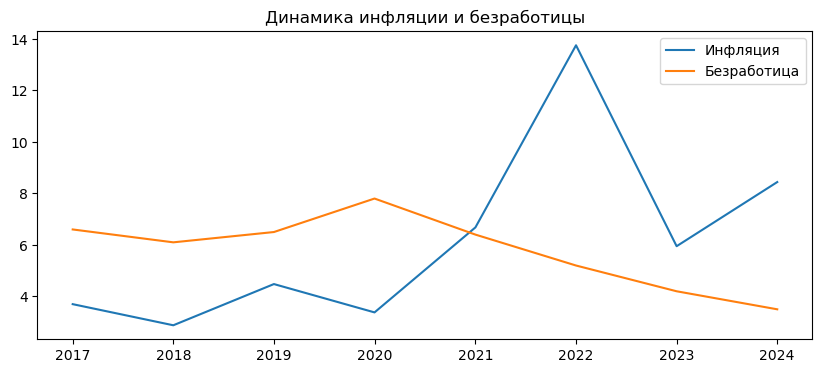

In [82]:
# # Пример данных
# inflation = np.array([1.5, 1.8, 2.0, 2.3, 2.1, 1.2, 2.7, 4.5])  # инфляция
# unemployment = np.array([6.2, 5.9, 5.4, 5.0, 4.7, 8.1, 6.0, 5.3])  # безработица

# Создаем DataFrame и добавляем лаг инфляции
df = pd.DataFrame({
    'inflation': inflation,
    'unemployment': unemployment
})
df['inflation_lag'] = df['inflation'].shift(1)
df.dropna(inplace=True)

y = df['inflation'].values
X = df[['inflation_lag', 'unemployment']].values

# Нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Проверяем размерности
print("endog shape:", y.shape)
print("exog shape:", X.shape)

# Класс модели NAIRU с фильтром Калмана
class NAIRUModel(MLEModel):
    start_params = [1.0, 0.5, -0.5, 0.1, 0.1]  # Начальные параметры
    param_names = ['const', 'alpha', 'beta', 'sigma_eps', 'sigma_eta']

    def __init__(self, endog, exog=None, **kwargs):
        self.exog = exog
        self.k_exog = exog.shape[1] if exog is not None else 0

        super(NAIRUModel, self).__init__(endog=endog, exog=exog, k_states=1, **kwargs)

        # Инициализация матриц
        nobs = len(endog)
        self['design'] = np.zeros((1, 1, nobs))  # Z
        self['transition'] = np.array([[1.0]])    # T
        self['selection'] = np.array([[1.0]])     # R
        self['obs_cov'] = np.array([[1.0]])       # H
        self['obs_intercept'] = np.zeros((1, nobs))  # c
        self['state_cov'] = np.array([[1.0]])      # Q
        
        self.initialize_approximate_diffuse()

    def update(self, params, **kwargs):
        const, alpha, beta, sigma_eps, sigma_eta = params

        # design matrix (Z): влияние NAIRU_t на инфляцию
        self['design', 0, 0, :] = -beta  # π_t зависит от NAIRU_t через β

        if self.exog is not None:
            pi_t_lag = self.exog[:, 0]
            u_t = self.exog[:, 1]
            self['obs_intercept', 0, :] = const + alpha * pi_t_lag + beta * u_t
        else:
            self['obs_intercept', 0, :] = const

        # Шумы
        self['state_cov', 0, 0] = sigma_eta**2
        self['obs_cov', 0, 0] = sigma_eps**2

# Создаем модель
model = NAIRUModel(endog=y, exog=X)

# Оцениваем параметры
res = model.fit(method='lbfgs', maxiter=200, disp=False)

# Выводим результаты
print("\nОцененные параметры:")
print(res.params)

# Получаем оценки NAIRU
nairu_estimated = res.smoothed_state[0]

print("\nОценённые значения NAIRU по годам:")
for i, val in enumerate(nairu_estimated):
    print(f"Период {i}: {val:.2f}")


plt.figure(figsize=(10, 4))
plt.plot(df.index, df['inflation'], label='Инфляция')
plt.plot(df.index, df['unemployment'], label='Безработица')
plt.legend()
plt.title('Динамика инфляции и безработицы')
plt.show()

endog shape: (8,)
exog shape: (8, 2)

Оцененные параметры:
[ 1.14296282  0.         -0.1         2.68109801 17.68251452]

Оценённые значения NAIRU по годам:
Период 0: 28.47
Период 1: 29.47
Период 2: 35.63
Период 3: 42.54
Период 4: 57.56
Период 5: 73.32
Период 6: 66.33
Период 7: 67.82


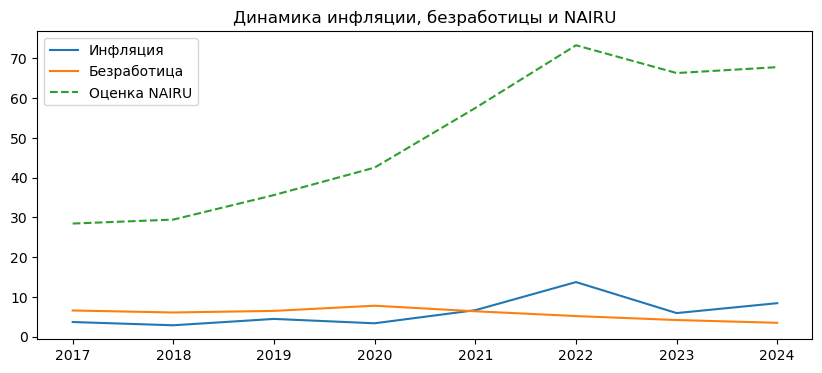

In [83]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', ValueWarning)

# Загрузка данных
data = pd.read_excel("./data/Infl_unempl.xlsx", parse_dates=["Date"])
data = data.dropna()
data = data.sort_values("Date").reset_index(drop=True)
data.set_index("Date", inplace=True)

inflation = data["Inflation"]
unemployment = data["Unempoyment"]

# Создаем DataFrame и добавляем лаг инфляции
df = pd.DataFrame({
    'inflation': inflation,
    'unemployment': unemployment
})
df['inflation_lag'] = df['inflation'].shift(1)
df.dropna(inplace=True)

y = df['inflation'].values
X = df[['inflation_lag', 'unemployment']].values

# Нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("endog shape:", y.shape)
print("exog shape:", X_scaled.shape)

# Класс модели NAIRU
class NAIRUModel(MLEModel):
    start_params = [0.0, 0.5, -1.0, 1.0, 1.0]
    param_names = ['const', 'alpha', 'beta', 'sigma_eps', 'sigma_eta']

    def __init__(self, endog, exog=None, **kwargs):
        self.exog = exog
        super(NAIRUModel, self).__init__(endog=endog, exog=exog, k_states=1, **kwargs)

        nobs = len(endog)
        self['design'] = np.zeros((1, 1, nobs))
        self['transition'] = np.array([[1.0]])
        self['selection'] = np.array([[1.0]])
        self['obs_cov'] = np.array([[1.0]])
        self['state_cov'] = np.array([[1.0]])
        self['obs_intercept'] = np.zeros((1, nobs))

        self.initialize_approximate_diffuse()

    def update(self, params, **kwargs):
        const, alpha, beta, sigma_eps, sigma_eta = params

        pi_t_lag = self.exog[:, 0]
        u_t = self.exog[:, 1]

        self['design', 0, 0, :] = -beta
        self['obs_intercept', 0, :] = const + alpha * pi_t_lag + beta * u_t

        self['state_cov', 0, 0] = sigma_eta**2
        self['obs_cov', 0, 0] = sigma_eps**2

# Создаем модель
model = NAIRUModel(endog=y, exog=X_scaled)

# Оцениваем параметры с ограничениями
res = model.fit(
    method='lbfgs',
    maxiter=500,
    disp=False,
    bounds=[
        (-5, 5),         # const
        (0, 1),          # alpha
        (-5, -0.1),      # beta < 0
        (0.01, None),    # sigma_eps
        (0.01, None)     # sigma_eta
    ]
)

# Выводим результаты
print("\nОцененные параметры:")
print(res.params)

# Получаем оценки NAIRU
nairu_estimated = res.smoothed_state[0]

print("\nОценённые значения NAIRU по годам:")
for i, val in enumerate(nairu_estimated):
    print(f"Период {i}: {val:.2f}")

# График
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['inflation'], label='Инфляция')
plt.plot(df.index, df['unemployment'], label='Безработица')
plt.plot(df.index, nairu_estimated, '--', label='Оценка NAIRU')
plt.legend()
plt.title('Динамика инфляции, безработицы и NAIRU')
plt.show()